# Trabalho Prático 1: Compressão de Imagens

**Grupo**:

- Isis Ferreira Carvalho (2020006663)
- Lucas Mesquita Andrade (2020054668)
- Victor Augusto de Lima Cruz (2020054854)

## Ideia

Comparar a performance da compressão JPEG utilizando várias transformadas diferentes.

{elaborar}

## Implementação

In [291]:
# Importações
%matplotlib inline
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter
import heapq
import struct
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [315]:
"""
    Função de leitura de dados e conversão pra escala de cinza
    Retorna: imagem original convertida para grayscale (ou imagem original se ela já está em grayscale)
"""
def ConvertToPgm(filepath, outpath):
    try:
        color_image = cv2.imread(filepath)
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        gray_image_8bit = cv2.convertScaleAbs(gray_image)
    except:
        return cv2.imread(filepath, 0)
    
    if color_image is None:
        print(f"Couldn't read file")

    cv2.imwrite(outpath, gray_image_8bit)
    return gray_image_8bit


In [316]:
img = ConvertToPgm('img/lena512.png', 'img/lena512_gray.pgm')
img

In [317]:
img

### Huffman

In [304]:
""" 
    Lógica da Codificação de Huffman, com métodos de codificação e decodificação 
"""

# Calcula frequências dos tons de cinza 
def calculate_frequencies(arr):
    flattened = arr.flatten()
    return Counter(flattened)

# Classe que implementa o nó da árvore para Codificação de Huffman
class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Constrói árvore de Huffman usando heap e pegando elemento mínimo 
def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)
    return codebook

def encode_array(arr, codebook):
    flattened = arr.flatten()
    encoded_bits = ''.join(codebook[value] for value in flattened)
    return encoded_bits

def save_encoded_data(encoded_bits, codebook, original_shape, file_path):
    with open(file_path, 'wb') as f:
        # Save the original shape
        f.write(struct.pack('>II', *original_shape))
        codebook_converted = {int(k): v for k, v in codebook.items()}
        
        # Save the codebook
        codebook_str = json.dumps(codebook_converted)
        f.write(struct.pack('>I', len(codebook_str)))
        f.write(codebook_str.encode('utf-8'))
        
        # Save the encoded bitstream length
        bitstream_len = len(encoded_bits)
        f.write(struct.pack('>I', bitstream_len))
        
        # Save the encoded bitstream
        byte_array = bytearray()
        for i in range(0, bitstream_len, 8):
            byte = encoded_bits[i:i+8]
            byte_array.append(int(byte.ljust(8, '0'), 2))
        f.write(byte_array)

def load_encoded_data(file_path):
    with open(file_path, 'rb') as f:
        # Read the original shape
        original_shape = struct.unpack('>II', f.read(8))
        
        # Read the codebook
        codebook_len = struct.unpack('>I', f.read(4))[0]
        codebook_str = f.read(codebook_len).decode('utf-8')
        codebook = json.loads(codebook_str)
        
        # Read the encoded bitstream length
        bitstream_len = struct.unpack('>I', f.read(4))[0]
        
        # Read the encoded bitstream
        bitstream_bytes = f.read()
        encoded_bits = ''.join(format(byte, '08b') for byte in bitstream_bytes)[:bitstream_len]
    
    return encoded_bits, codebook, original_shape

def decode_huffman(encoded_bits, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_values = []
    
    current_bits = ''
    for bit in encoded_bits:
        current_bits += bit
        if current_bits in reverse_codebook:
            decoded_values.append(reverse_codebook[current_bits])
            current_bits = ''
    
    return decoded_values

def bits_to_array(decoded_values, original_shape):
    return np.array(decoded_values).reshape(original_shape)

### JPEG

In [305]:
"""
    Função que faz o padding da imagem caso sua altura ou largura não sejam múltiplos de 8
"""
def pad_image(img, block_size):

    width, height = img.shape[0], img.shape[1]

    if width % 8 != 0 or height % 8 != 0:
        #padding é necessário
        height = np.float32(height) 
        width = np.float32(width) 

        new_width = np.int32(math.ceil(width/block_size) * block_size)
        new_height = np.int32(math.ceil(height/block_size) * block_size)

        padded_img = np.zeros((new_width, new_height))
        padded_img[0:int(width),0:int(height)] = img[0:int(width),0:int(height)]

        width, height = new_width, new_height
        cv2.imwrite('padded_img.bmp', np.uint8(padded_img)) #inserir nome na representação intermediária do file
    else:
        padded_img = img

    return padded_img, width, height

In [306]:
"""
    Funções de aplicação de transformadas e suas inversas
"""
def apply_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def apply_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

In [307]:
"""
    Função de caminhamento em zigzag na matriz pós-transofrmada e quantização, para captar maiores coeficientes primeiro
    {TO-DO: melhorar comentários como se fossem nossos}
"""

def zigzag(input):
    h, v = 0, 0
    vmin, hmin = 0, 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros((vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[i] = input[v, h]        # if we got to the first line
                if (h == hmax):
                    v += 1
                else:
                    h += 1
                i += 1
            elif ((h == hmax - 1) and (v < vmax)):   # if we got to the last column
                output[i] = input[v, h]
                v += 1
                i += 1
            elif ((v > vmin) and (h < hmax - 1)):    # all other cases
                output[i] = input[v, h]
                v -= 1
                h += 1
                i += 1
        else:                                    # going down
            if ((v == vmax - 1) and (h <= hmax - 1)):       # if we got to the last line
                output[i] = input[v, h]
                h += 1
                i += 1
            elif (h == hmin):                  # if we got to the first column
                output[i] = input[v, h]
                if (v == vmax - 1):
                    h += 1
                else:
                    v += 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):     # all other cases
                output[i] = input[v, h]
                v += 1
                h -= 1
                i += 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[i] = input[v, h]
            break

    return output.astype(int)

def unzigzag(input, vmax, hmax):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    i = 0
    
    output = np.zeros((vmax, hmax))
    
    while ((v < vmax) and (h < hmax)): 
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[v, h] = input[i]        # if we got to the first line
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                output[v, h] = input[i] 
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                output[v, h] = input[i] 
                v = v - 1
                h = h + 1
                i = i + 1

        else:                                    # going down
            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                output[v, h] = input[i] 
                h = h + 1
                i = i + 1
            elif (h == hmin):                  # if we got to the first column
                output[v, h] = input[i] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1                
            elif((v < vmax -1) and (h > hmin)):     # all other cases
                output[v, h] = input[i] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element        
            output[v, h] = input[i] 
            break


    return output

In [250]:
"""
    Declaração da matriz de quantização a ser usada na codificação
"""
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [251]:
""" 
    {TO-DO: DAR UNS PRINT EM RESULTADOS INTERMEDIÁRIOS, COMENTAR, PENSAR MELHRO NO FLUXO}
"""
def encode_jpeg(img, transformada, quantiz_matrix, encoded_file_path='encoded_image.bin', plot=False):
    img = img.astype(float)
    img = img - 128
    block_size = 8
    padded_img, width, height = pad_image(img, block_size)
    # num_blocks_w, num_blocks_h = width/block_size, height/block_size

    new_img = np.zeros((width, height)).astype(int) # Para guardar representação pós transformada, quantização e zigzag

    for x in range(0, width, block_size):
        for y in range(0, height, block_size):
            block = padded_img[x:x+block_size, y:y+block_size]
            dct = transformada(block)
            dct_quantized = np.round(np.divide(dct, quantiz_matrix)).astype(int)
            dct_zigzag = zigzag(dct_quantized)
            reshaped = np.reshape(dct_zigzag, (block_size, block_size))
            new_img[x:x+block_size, y:y+block_size] = reshaped #dct_quantized

    # HUFFMAN
    arr = np.array(new_img)
    frequencies = calculate_frequencies(arr)
    huffman_tree = build_huffman_tree(frequencies)
    codebook = generate_huffman_codes(huffman_tree)
    encoded_bits = encode_array(arr, codebook)
    save_encoded_data(encoded_bits, codebook, img.shape, encoded_file_path)

    if plot:
        plt.imshow(img+128, cmap = 'gray', clim=(0, 255))
        plt.show()
        plt.imshow(new_img, cmap = 'gray', clim=(0, 255))
        plt.show()

    return new_img

In [252]:
def decode_jpeg(encoded_file_path, transformada, quantiz_matrix, plot=False):
    encoded_bits_read, codebook_read, original_shape_read = load_encoded_data(encoded_file_path)
    (orig_w, orig_h) = original_shape_read

    if orig_w % 8 != 0:
        padded_w = orig_w + 8 - (orig_w % 8)
    else:
        padded_w = orig_w
    if orig_h % 8 != 0:
        padded_h = orig_h + 8 - (orig_h % 8)
    else:
        padded_h = orig_h
            
    codebook_treated = {int(k):v for k,v in codebook_read.items()}
    decoded_values = decode_huffman(encoded_bits_read, codebook_treated)
    reconst_matrix = bits_to_array(decoded_values, (padded_w, padded_h))     # Final da decodificação de Huffman

    reconst_img = np.zeros((padded_w, padded_h)).astype(int)

    block_size = 8
    for x in range(0, padded_w, block_size):
        for y in range(0, padded_h, block_size):
            block = reconst_matrix[x:x+block_size, y:y+block_size]
            block = unzigzag(block.flatten(), block_size, block_size)
            reconst_dequantized = np.multiply(block, quantiz_matrix).astype(int)
            inverse_dct = transformada(reconst_dequantized)
            reconst_img[x:x+block_size, y:y+block_size] = inverse_dct

    reconst_img = reconst_img[:orig_w, :orig_h]
    reconst_img += 128

    reconst_img = np.uint8(reconst_img)

    if plot:
        plt.imshow(reconst_img, cmap = 'gray', clim=(0, 255))

    return reconst_img

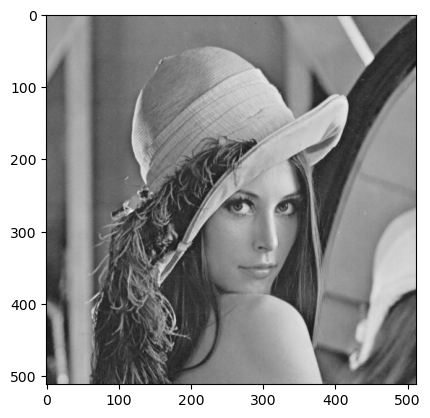

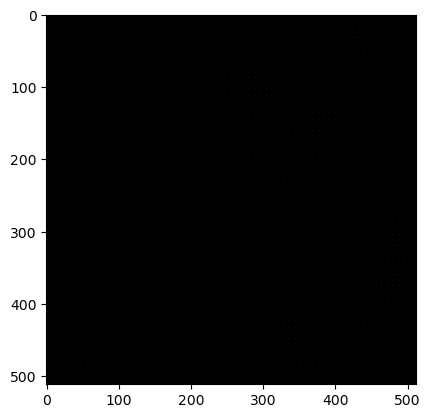

In [253]:
new_img = encode_jpeg(img, apply_dct, QM, plot=True)

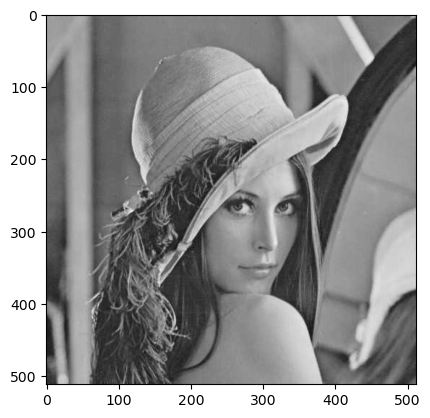

In [254]:
reconstructed_img = decode_jpeg('encoded_image.bin', apply_idct, QM, plot=True)

In [255]:
reconstructed_img.tofile('testfile.pgm')

# Experimentos

In [290]:
vou organizando o código enquanto isso
MALDITO LZ....
não dá pra entender

SyntaxError: invalid syntax (1171203929.py, line 1)

In [289]:
# implementação do Professor
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

In [266]:
def convertToPgm(filepath, outpath):
    color_image = cv2.imread(filepath)

    if color_image is None:
        print(f"Couldn't read file")

    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    gray_image_8bit = cv2.convertScaleAbs(gray_image)
    cv2.imwrite(outpath, gray_image_8bit)

In [267]:
def aux_jpeg_encode(img, output_filepath):
    encode_jpeg(img, apply_dct, QM, output_filepath)

def aux_jpeg_decode(output_filepath):
    return decode_jpeg(output_filepath, apply_idct, QM)

In [268]:
import math

In [276]:
def evaluateCompression(compressionFunction, decompressionFunction):
    files = os.listdir('img')
    df = pd.DataFrame()
    for file in files:
        input_filepath = './img/' + file
        output_filepath = './tmp/' + file
        
        imageMatrix = cv2.imread(input_filepath, 0)
        if imageMatrix is None:
            continue

        compressionFunction(imageMatrix, output_filepath)
        decompressedImageMatrix = decompressionFunction(output_filepath)
        print(f'min: {decompressedImageMatrix.min()}, max: {decompressedImageMatrix.max()}')
        compression_rate = os.path.getsize(input_filepath) / os.path.getsize(output_filepath)
        psnr_imgs = psnr(imageMatrix, decompressedImageMatrix)
        
        df = df.append({'file': file, 
                        'shape': imageMatrix.shape,
                        'result_shape': imageMatrix.shape,
                        'compression_rate': compression_rate,
                        'psnr': psnr_imgs
                       }, ignore_index=True)
        
    return df
    

não era só future warning
que se foda o futuro
kkkkkkkkkkk
vou desativar os future warnings

In [277]:
evaluation_df = evaluateCompression(aux_jpeg_encode, aux_jpeg_decode)

min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 7, max: 250
min: 0, max: 255
min: 9, max: 254
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 14, max: 252
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 0, max: 255
min: 6, max: 247
min: 0, max: 255
min: 0, max: 253
min: 4, max: 229
min: 0, max: 255
min: 0, max: 190
min: 0, max: 254


In [263]:
evaluation_df

,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",6.235749,2.979974
1,barbara.pgm,"(512, 512)","(512, 512)",4.757258,3.568473
2,boats.pgm,"(576, 720)","(576, 720)",5.355932,3.911134
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",6.773264,3.739955
4,Brain1.pgm,"(911, 699)","(911, 699)",5.134791,4.737027
5,Brain2.pgm,"(901, 675)","(901, 675)",5.350173,4.908674
6,Brain3.pgm,"(867, 691)","(867, 691)",5.024319,4.905869
7,Brain4.pgm,"(881, 719)","(881, 719)",5.529411,5.011996
8,Brain5.pgm,"(903, 713)","(903, 713)",5.527885,5.095146
9,bridge.pgm,"(512, 512)","(512, 512)",4.103968,3.418098


In [272]:
evaluation_df

,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",6.235749,34.836174
1,barbara.pgm,"(512, 512)","(512, 512)",4.757258,34.070900
2,boats.pgm,"(576, 720)","(576, 720)",5.355932,36.301283
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",6.773264,41.803347
4,Brain1.pgm,"(911, 699)","(911, 699)",5.134791,40.388619
5,Brain2.pgm,"(901, 675)","(901, 675)",5.350173,41.372263
6,Brain3.pgm,"(867, 691)","(867, 691)",5.024319,39.784053
7,Brain4.pgm,"(881, 719)","(881, 719)",5.529411,42.816451
8,Brain5.pgm,"(903, 713)","(903, 713)",5.527885,42.861801
9,bridge.pgm,"(512, 512)","(512, 512)",4.103968,31.700034


In [275]:
evaluation_df

,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",6.235749,34.315691
1,barbara.pgm,"(512, 512)","(512, 512)",4.757258,32.357932
2,boats.pgm,"(576, 720)","(576, 720)",5.355932,35.832480
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",6.773264,33.303072
4,Brain1.pgm,"(911, 699)","(911, 699)",5.134791,20.621728
5,Brain2.pgm,"(901, 675)","(901, 675)",5.350173,18.826830
6,Brain3.pgm,"(867, 691)","(867, 691)",5.024319,20.255404
7,Brain4.pgm,"(881, 719)","(881, 719)",5.529411,20.959444
8,Brain5.pgm,"(903, 713)","(903, 713)",5.527885,22.439636
9,bridge.pgm,"(512, 512)","(512, 512)",4.103968,23.435704


### Comprimento de corrida

In [89]:
new_img.astype('uint8').tofile('test_file.txt')

In [90]:
# contém dúvida

In [91]:
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " +str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream

In [92]:
arranged = new_img.flatten()

# Now RLE encoded data is written to a text file (You can check no of bytes in text file is very less than no of bytes in the image
# THIS IS COMPRESSION WE WANTED, NOTE THAT ITS JUST COMPRESSION DUE TO RLE, YOU CAN COMPRESS IT FURTHER USING HUFFMAN CODES OR MAY BE 
# REDUCING MORE FREQUENCY COEFFICIENTS TO ZERO)

bitstream = get_run_length_encoding(arranged)

In [93]:
bitstream

'16 0 1 1 16 5 2 0 1 0 14 5 1 0 1 0 -1 3 13 1 1 4 15 2 -2 0 1 0 1 2 -1 1 21 0 -2 0 -1 3 20 2 3 0 -1 3 2 2 11 0 1 0 -1 2 -1 1 -17 0 1 1 -1 0 2 1 -12 2 -2 0 1 0 1 1 -11 3 1 1 1 2 -11 2 -1 0 1 0 -11 5 1 1 1 1 -7 3 -2 0 -3 6 -1 0 -1 0 -1 2 -1 2 -1 0 1 0 1 2 -1 0 1 1 1 0 2 6 1 0 1 0 1 1 1 3 1 5 2 1 -1 0 3 6 -1 0 3 6 2 7 1 0 2 6 1 1 3 5 1 1 3 5 1 0 1 0 3 5 1 0 1 6 2 7 -1 4 2 2 1 1 1 2 3 2 1 1 1 4 2 0 -1 0 1 3 2 2 2 0 1 2 1 3 1 1 1 5 -1 0 1 0 -1 6 -1 11 -3 10 1 0 -9 6 3 0 -1 3 -4 2 -8 0 1 0 -1 0 -1 2 11 1 -4 0 1 0 -1 2 -1 0 15 1 1 0 -1 3 12 2 -1 0 -1 2 13 3 1 1 -1 2 14 2 1 0 12 6 13 7 -1 4 14 2 -1 4 14 2 1 0 -1 3 25 2 -15 0 3 0 -1 0 1 1 1 0 -1 0 43 0 -2 0 -1 3 32 2 19 0 -4 0 2 0 3 0 -7 0 2 0 -11 1 -1 1 1 0 -2 0 3 0 1 0 -1 0 -5 0 -1 0 1 0 -4 5 1 4 1 0 -3 1 1 0 -1 3 -3 2 1 4 -2 2 -3 7 1 0 1 2 -1 0 1 0 -1 1 -1 0 -1 6 1 0 -1 3 -4 2 -1 0 -2 0 1 0 4 4 7 0 18 0 -9 0 -6 0 -8 0 1 0 -3 0 -1 61 -1 0 1 151 -1 38 1 64 1 82 1 2 -2 11 -1 0 -1 4 1 1 -1 2 1 0 -1 0 2 74 3 0 2 2 -1 1 -1 505 -1 1 -1 0 14 2564 -1

In [94]:
new_img[0][0:10]

array([16,  0,  1,  0,  0,  0,  0,  0, 16,  2])

In [95]:
bitstream = str(new_img.shape[0]) + " " + str(new_img.shape[1]) + " " + bitstream + ";"

# Written to image.txt
file1 = open("image.txt","w")
file1.write(bitstream)
file1.close()